← Reusing cached SpatialData.
← Reusing cached H&E image and pixel sizes.
← Using provided SpatialData and H&E image, skipping load_data.
→ Filtering cells based on transcript counts...
→ Filtering cells based on transcript_counts...
✓ Selected 147698 cells with transcript_counts ≥ 67.0
→ Extracting cell centroids...
→ Extracting centroids from AnnData...
✓ Successfully extracted 190965 cell coordinates
Sample coordinates: [[793.26062012 843.56097412]
 [816.53790283 788.01574707]
 [558.50939941 852.34869385]]
Sample cell IDs: ['aaaanbjb-1' 'aaabbnlb-1' 'aaabdean-1']
✓ Keeping 147698 centroids after filtering
→ Converting and aligning centroids from µm → pixels...
→ Loading pre-computed aligned coordinates...
✓ Loaded 190965 aligned coordinates
✔ Sample pixel coords: [[5429.47589346 8460.57975928]
 [5165.73262779 8331.63242989]
 [5431.42395546 9578.87786533]
 [5163.20394399 8314.87656124]
 [5051.92274909 8258.51413609]] 

→ Sampled 246 cells

→ Fast downsample to (7188, 2056) via slicin

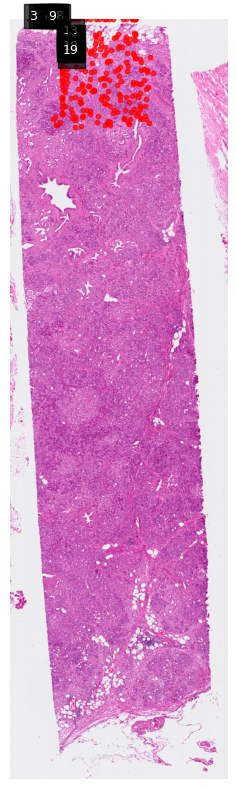

→ Extracting patches for sampled cells …
→ Selected 50 indices for patch extraction


IndexError: index 168770 is out of bounds for axis 0 with size 147698

In [ ]:
"""
COMPREHENSIVE ANNOTATION:
Cell Patch Extraction Pipeline for Xenium Spatial Transcriptomics Data

This code performs extraction and quality assessment of cell patches from H&E (Hematoxylin and Eosin) 
stained histology images, aligned with spatial transcriptomics data from the Xenium platform. 
The goal is to extract image patches centered around cell nuclei detected in Xenium data.

Key functionalities:
1. Loading spatial transcriptomics data and corresponding H&E images
2. Converting nucleus coordinates from microns to pixels
3. Sampling cells in a spatially distributed manner
4. Extracting image patches at multiple zoom levels (kappa values)
5. Evaluating the quality of extracted patches
6. Selecting the best patches based on quality metrics

The pipeline serves as a preprocessing step for downstream analysis that combines 
histological features with gene expression data at single-cell resolution.
"""

import os
import time
import random
import xml.etree.ElementTree as ET  # For parsing XML metadata in OME-TIFF files

# Numerical and data processing libraries
import numpy as np  # For efficient numerical operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For visualization

# Image processing libraries
from scipy import ndimage  # For image transformations like distance transforms
from skimage import exposure, filters, measure, color, transform  # For advanced image processing
from tifffile import TiffFile  # For reading TIFF files with metadata
import spatialdata as sd  # Library for spatial transcriptomics data

from tqdm.notebook import tqdm  # Progress bar for Jupyter notebooks

# =============================================================================
# Module-level cache for heavy data
# =============================================================================
# Why use module-level caching? 
# Answer: Loading large spatial datasets and high-resolution images is computationally expensive.
# Caching these objects prevents redundant loading operations, significantly improving performance
# when functions are called multiple times.
# _cached_sdata = None  # Cache for SpatialData object
# _cached_he_image = None  # Cache for H&E image
# _cached_pixel_size = None  # Cache for pixel size (psx, psy) in microns

# Paths to data files
# Why hardcode paths?
# Answer: While not ideal for production, hardcoding simplifies development and testing.
# In a production environment, these would be parameterized or loaded from configuration.
base_dir      = "/Users/jianzhouyao/Cancer"
xenium_dir    = os.path.join(base_dir, "Pancreatic Cancer with Xenium Human Multi-Tissue and Cancer Panel")
zarr_path     = os.path.join(xenium_dir, "Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs.zarr")
he_image_path = os.path.join(xenium_dir, "Xenium_V1_hPancreas_Cancer_Add_on_FFPE_he_image.ome.tif")

# =============================================================================
# Data loading with caching
# =============================================================================
def load_data():
    """
    Load SpatialData and H&E image (with OME metadata) once and cache globally.
    
    Why use this function pattern?
    Answer: It implements a lazy loading pattern with caching. Data is loaded only when needed
    and stored for future use, preventing redundant loading operations.
    
    Returns:
        sdata: SpatialData object containing spatial transcriptomics data
        he_image: H&E image as ndarray (Height, Width, Channels)
        psx, psy: pixel size in microns (physical dimensions of each pixel)
    """
    global _cached_sdata, _cached_he_image, _cached_pixel_size
    _cached_sdata = globals().get("_cached_sdata", None)
    _cached_he_image = globals().get("_cached_he_image", None)
    _cached_pixel_size = globals().get("_cached_pixel_size", None)
    
    # Load SpatialData if not already cached
    if _cached_sdata is None:
        print("→ Loading SpatialData Zarr …")
        _cached_sdata = sd.read_zarr(zarr_path)  # Load data from Zarr storage format
        print("✔ SpatialData loaded.")
    else:
        print("← Reusing cached SpatialData.")

    # Load H&E image and metadata if not already cached
    if _cached_he_image is None or _cached_pixel_size is None:
        print("→ Loading H&E TIFF (memmap) & reading OME metadata …")
        
        # Why use memmap?
        # Answer: Memory mapping allows files to be accessed without loading the entire file into
        # memory, which is crucial for large image files that might exceed available RAM.
        with TiffFile(he_image_path) as tif:
            img = tif.asarray(out='memmap')  # Load image as memory-mapped array
            ome_xml = tif.ome_metadata  # Extract OME metadata
        
        # Why check and potentially transpose the image?
        # Answer: Standardizes the image dimensions to have channels as the last dimension (H,W,C),
        # regardless of how they were stored in the TIFF file (which might be C,H,W).
        if img.ndim == 3 and img.shape[0] in (1, 3):
            img = np.moveaxis(img, 0, -1)  # Convert from (C,H,W) to (H,W,C) format
        
        # Parse OME-XML metadata to extract pixel size information
        # Why use ElementTree and namespaces?
        # Answer: OME-TIFF follows a standardized XML schema with specific namespaces.
        # Using ElementTree with appropriate namespaces ensures correct parsing.
        root = ET.fromstring(ome_xml)
        ns = {'ns': 'http://www.openmicroscopy.org/Schemas/OME/2016-06'}
        pixels = root.find('.//ns:Pixels', ns)

        # Extract physical pixel size in microns
        # Why default to 1.0?
        # Answer: Ensures the code doesn't fail if the metadata is missing.
        # A value of 1.0 implies 1 pixel = 1 micron as a fallback.
        psx = float(pixels.attrib.get('PhysicalSizeX', 1.0))
        psy = float(pixels.attrib.get('PhysicalSizeY', 1.0))

        # Store loaded data in cache
        _cached_he_image = img
        _cached_pixel_size = (psx, psy)
        
        print(f"✔ H&E loaded (shape={img.shape}), pixel sizes: X={psx} µm, Y={psy} µm")
    else:
        print("← Reusing cached H&E image and pixel sizes.")
        img = _cached_he_image
        psx, psy = _cached_pixel_size

    return _cached_sdata, img, psx, psy

# -----------------------------------------------------------------------------
# QC & preprocessing functions
# -----------------------------------------------------------------------------
def paper_specific_qc(patches, qr):
    """
    Apply additional quality control specific to paper requirements.
    
    Why add paper-specific QC?
    Answer: This addresses issues specific to the analysis pipeline or publication
    requirements that weren't covered by the general QC. In this case, it removes
    completely black patches at the largest zoom level.
    
    Parameters:
        patches: Dictionary of patches per cell
        qr: Quality results
        
    Returns:
        Updated patches and quality results
    """
    # Identify completely black patches at kappa=2.0
    to_rm = []
    for cid in patches:
        for i,q in enumerate(qr[cid]):
            if q['kappa']==2.0 and patches[cid][i].mean()<5:
                to_rm.append((cid,i))
    
    print(f"Removing {len(to_rm)} completely black κ=2.0 patches")
    
    # Mark identified patches as invalid
    for cid,i in to_rm:
        qr[cid][i]['is_valid']=False
        qr[cid][i]['reason']="Completely black patch"
    
    return patches, qr

def mad_filter_cells(sdata, column="transcript_counts", threshold=5, verbose=True):
    """
    Filter cells based on MAD (Median Absolute Deviation) of transcript counts
    """
    if verbose:
        print(f"→ Filtering cells based on {column}...")
    
    # Get the AnnData table
    adata = sdata.tables["table"]
    
    # Ensure the column exists
    if column not in adata.obs.columns:
        count_cols = [col for col in adata.obs.columns if 'count' in col.lower()]
        if count_cols:
            column = count_cols[0]
            print(f"Column '{column}' not found, using '{column}' instead")
        else:
            print(f"No count column found, returning all cells")
            return adata.obs["cell_id"].values, 0
    
    # Get the counts and calculate MAD threshold
    counts = pd.to_numeric(adata.obs[column]) # Convert to numeric if needed
    median_value = np.median(counts) # Calculate median
    mad = np.median(np.abs(counts - median_value)) # Calculate MAD
    # Calculate threshold
    mad_threshold = median_value + threshold * mad
    mad_threshold = max(mad_threshold, threshold)  # Ensure threshold is not below minimum
    mad_threshold = min(mad_threshold, counts.max())  # Ensure threshold is not above maximum
    mad_threshold = max(mad_threshold, 0)  # Ensure threshold is not negative
    # Print MAD and threshold for debugging
    if verbose:
        print(f"MAD: {mad:.1f}, Threshold: {mad_threshold:.1f}")
        print(f"Median: {median_value:.1f}, Max: {counts.max():.1f}")
        print(f"Min: {counts.min():.1f}")
        print(f"Mean: {counts.mean():.1f}")

    # Set minimum threshold (either MAD-based or user-provided)
    if mad < 1e-10:  # Handle edge case
        mad_threshold = threshold
        print(f"MAD is too small, using minimum threshold {threshold}")
    else:
        mad_threshold = max(median_value - mad, threshold)
    
    # Apply threshold
    valid_mask = counts >= mad_threshold
    valid_cell_ids = adata.obs.loc[valid_mask, "cell_id"].values
    
    if verbose:
        print(f"✓ Selected {len(valid_cell_ids)} cells with {column} ≥ {mad_threshold:.1f}")
    
    return valid_cell_ids, mad_threshold

def extract_xenium_nucleus_centroids_from_spatialdata(sdata):
    """
    Extract nucleus centroids directly from AnnData spatial coordinates
    """
    print("→ Extracting centroids from AnnData...")
    
    # Get the AnnData object
    adata = sdata.tables["table"]
    
    # Get spatial coordinates and cell IDs
    if "spatial" in adata.obsm:
        # Extract coordinates directly from obsm["spatial"]
        nucleus_centroids = adata.obsm["spatial"]
        cell_ids = adata.obs["cell_id"].values
        print(f"✓ Successfully extracted {len(nucleus_centroids)} cell coordinates")
        
        # Show first few coordinates and IDs for verification
        print(f"Sample coordinates: {nucleus_centroids[:3]}")
        print(f"Sample cell IDs: {cell_ids[:3]}")
        
        return nucleus_centroids, cell_ids
    
    # Fallback to using shape geometries if spatial not available
    elif 'nucleus_boundaries' in sdata.shapes:
        print("Using nucleus_boundaries geometries (fallback)")
        nucleus_shapes = sdata.shapes['nucleus_boundaries']
        nucleus_centroids = np.array([
            (geom.centroid.x, geom.centroid.y) 
            for geom in nucleus_shapes.geometry
        ])
        cell_ids = nucleus_shapes.index.values
        return nucleus_centroids, cell_ids
    
    # Final fallback
    else:
        raise ValueError("Could not find spatial coordinates in the SpatialData object")

def sample_grid_cells(centroids, grid_size=8, cells_per_grid=5):
    """
    Sample cells from a spatial grid for balanced representation.
    
    Why use grid sampling?
    Answer: Random sampling might oversample dense regions and undersample sparse ones. -> some regions may have many detected cells (high density), while others are sparse
    If you randomly sample cells, you'll likely pick many from dense regions and miss spatially interesting areas.
    Grid sampling samples cells evenly across space using a grid.
    
    Parameters:
        centroids: Array of (x,y) coordinates
        grid_size: Number of grid divisions in each dimension -> Default = 8 → 8×8 = 64 grid cells.
        cells_per_grid: Maximum cells to sample from each grid cell -> Default = 5
        
    Returns:
        Array of indices of sampled cells
    """
    xs, ys = centroids[:,0], centroids[:,1]
    xmin,xmax, ymin,ymax = xs.min(), xs.max(), ys.min(), ys.max()
    
    # Calculate grid cell sizes
    dx, dy = (xmax-xmin)/grid_size, (ymax-ymin)/grid_size
    
    out = []
    # Iterate through each grid cell
    for i in range(grid_size):
        for j in range(grid_size):
            # Find cells within current grid cell
            m = ((xs>=xmin+i*dx)&(xs<xmin+(i+1)*dx)&
                 (ys>=ymin+j*dy)&(ys<ymin+(j+1)*dy))
            idx = np.where(m)[0]
            
            # Sample cells from current grid cell
            if idx.size:
                take = min(cells_per_grid, idx.size)
                out.extend(np.random.choice(idx, take, replace=False))
    
    return np.array(out)

# =============================================================================
# Fast downsample preview via strided slicing
# =============================================================================
def create_downsampled_preview(he_image, coords_px, sample_indices, factor=10):
    """
    Create a downsampled preview of the H&E image with sampled cell locations.
    
    Why create a downsampled preview?
    Answer: Full-resolution H&E images can be extremely large (gigapixels). A downsampled
    preview allows quick visual verification of coordinate mapping and sampling without
    requiring excessive memory or computation.
    
    Parameters:
        he_image: Full H&E image
        coords_px: Pixel coordinates of all cells
        sample_indices: Indices of sampled cells
        factor: Downsampling factor
    """
    h, w = he_image.shape[:2]
    small_h, small_w = h // factor, w // factor
    print(f"→ Fast downsample to ({small_h}, {small_w}) via slicing …")
    
    # Downsample image via strided slicing
    # Why use slicing instead of interpolation?
    # Answer: Much faster for large images, and sufficient for preview purposes
    small_image = he_image[::factor, ::factor, :].astype(np.uint8)
    
    # Scale down coordinates to match downsampled image
    pts = coords_px[sample_indices] // factor
    x_pts, y_pts = pts[:, 0], pts[:, 1]
    
    # Visualize sampled points on downsampled image
    plt.figure(figsize=(8, 8))
    plt.imshow(small_image)
    plt.scatter(x_pts, y_pts, c='red', s=10, alpha=0.7)
    
    # Label first 20 points for reference
    for i, idx in enumerate(sample_indices[:20]):
        x, y = coords_px[idx] // factor
        plt.text(x + 5, y + 5, str(i), color='white', fontsize=9,
                 bbox=dict(facecolor='black', alpha=0.7))
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def align_and_convert_coordinates(centroids_um, he_image, psx, psy, xenium_dir):
    """
    Align Xenium coordinates with better path handling
    """
    # Try both possible transformation matrix paths
    possible_paths = [
        os.path.join(xenium_dir, "Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs", 
                    "Xenium_V1_hPancreas_Cancer_Add_on_FFPE_he_imagealignment.csv"),
        os.path.join(xenium_dir, "Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs", 
                    "he_imagealignment.csv")
    ]
    
    # Find the first existing path
    transform_path = None
    for path in possible_paths:
        if os.path.exists(path):
            transform_path = path
            break
    
    coords_px_path = os.path.join(xenium_dir, "aligned_coords_px.npy")
    
    # Check for pre-computed coordinates
    if os.path.exists(coords_px_path):
        print(f"→ Loading pre-computed aligned coordinates...")
        coords_px = np.load(coords_px_path)
        print(f"✓ Loaded {len(coords_px)} aligned coordinates")
        return coords_px
    
    # Convert microns to initial pixel coordinates
    print("→ Converting coordinates from µm to pixels...")
    initial_coords_px = np.zeros_like(centroids_um, dtype=float)
    initial_coords_px[:, 0] = centroids_um[:, 0] / psx
    initial_coords_px[:, 1] = centroids_um[:, 1] / psy
    
    # Check if transformation matrix exists
    if transform_path:
        print(f"→ Found transformation matrix at {transform_path}")
        try:
            transform_matrix = np.loadtxt(transform_path, delimiter=",")
            print(f"Matrix shape: {transform_matrix.shape}")
            
            # Apply transformation
            transform = AffineTransform(matrix=transform_matrix)
            coords_px = transform(initial_coords_px)
            
            # Verify the results make sense
            h, w = he_image.shape[:2]
            in_bounds = np.sum((0 <= coords_px[:, 0]) & (coords_px[:, 0] < w) & 
                              (0 <= coords_px[:, 1]) & (coords_px[:, 1] < h))
            print(f"Coordinates in image bounds: {in_bounds}/{len(coords_px)} ({in_bounds/len(coords_px)*100:.2f}%)")
            
        except Exception as e:
            print(f"Error applying transformation: {e}")
            print("Using direct conversion instead")
            coords_px = initial_coords_px
    else:
        print("No transformation matrix found, using direct conversion")
        coords_px = initial_coords_px
    
    # Convert to integers for pixel coordinates
    coords_px = np.round(coords_px).astype(int)
    
    # Save coordinates
    np.save(coords_px_path, coords_px)
    print(f"✓ Saved {len(coords_px)} aligned coordinates")
    
    return coords_px

from skimage.io import imread
from skimage.transform import estimate_transform, AffineTransform
import napari

def align_xenium_to_he(he_image, xenium_coords):
    """
    Manually pick landmarks using Napari to align Xenium coordinates to the H&E image.

    Parameters:
        he_image (ndarray): H&E image (H, W) or (H, W, C)
        xenium_coords (ndarray): Xenium centroid coordinates (N, 2)

    Returns:
        aligned_coords (ndarray): Transformed Xenium coordinates aligned to H&E space (N, 2)
        transform_matrix (ndarray): 3x3 affine transformation matrix
    """

    # Open napari viewer
    viewer = napari.Viewer()
    viewer.add_image(he_image, name="H&E Image")
    viewer.add_points(xenium_coords, name="Xenium Coordinates", size=10, face_color="red")

    # Create empty layers for user to pick landmarks
    he_points_layer = viewer.add_points(name="H&E Landmarks", size=10, face_color="blue")
    xenium_points_layer = viewer.add_points(name="Xenium Landmarks", size=10, face_color="green")

    print("\n💡 INSTRUCTIONS:")
    print("- Use the 'H&E Landmarks' layer to click landmarks on the H&E image.")
    print("- Use the 'Xenium Landmarks' layer to click corresponding points in Xenium space.")
    print("- Pick the same number of points in the same order.")
    print("- Close the napari window to continue.\n")

    napari.run()

    # Retrieve landmarks
    he_landmarks = he_points_layer.data
    xenium_landmarks = xenium_points_layer.data

    if len(he_landmarks) != len(xenium_landmarks):
        raise ValueError(f"❌ Mismatched landmarks: {len(he_landmarks)} (H&E) vs {len(xenium_landmarks)} (Xenium)")

    # Estimate affine transformation
    transform = estimate_transform('affine', src=xenium_landmarks, dst=he_landmarks)

    # Apply to all Xenium coordinates
    aligned_coords = transform(xenium_coords)

    print("✅ Transformation complete. Xenium coordinates aligned to H&E image.")

    return aligned_coords, transform.params

def apply_saved_transform(transform_path, new_coords_path, output_path):
    """
    Apply a saved affine transformation to new Xenium coordinates.

    Parameters:
        transform_path (str): Path to the saved transformation matrix (CSV).
        new_coords_path (str): Path to the new Xenium coordinates (CSV).
        output_path (str): Path to save the aligned coordinates (CSV).

    Returns:
        None
    """
    # Load saved transform matrix
    loaded_matrix = np.loadtxt(transform_path, delimiter=",")
    transform = AffineTransform(matrix=loaded_matrix)

    # Load new Xenium coordinates
    new_coords = np.loadtxt(new_coords_path, delimiter=",")

    # Apply the transformation
    aligned_new_coords = transform(new_coords)

    # Save the aligned coordinates
    np.savetxt(output_path, aligned_new_coords, delimiter=",")
    print(f"Aligned coordinates saved to {output_path}")

def extract_image_patches(he_image, transformed_coords,
                          P=224,
                          kappas=[0.5, 0.75, 1.0, 1.5, 2.0],
                          resample_order=3):
    """
    Extract 224×224 patches at zoom levels κ around each point, with detailed debug prints.
    """
    H, W = he_image.shape[:2]
    print(f"[DEBUG] Entering extract_image_patches: image shape=({H},{W}), "
          f"num_points={len(transformed_coords)}, P={P}, kappas={kappas}")
    
    patches = {}

    for i, (x, y) in enumerate(transformed_coords):
        xi, yi = int(round(x)), int(round(y))
        print(f"[DEBUG] Point {i}: rounded coords → (xi, yi)=({xi}, {yi})")
        
        # skip out‐of‐bounds
        if not (0 <= xi < W and 0 <= yi < H):
            print(f"[DEBUG] Point {i} is outside image bounds; skipping.")
            continue

        patches[i] = []
        for κ in kappas:
            # compute raw patch size to crop
            crop_size = int(np.ceil(P / κ))
            half = crop_size // 2
            print(f"[DEBUG]  κ={κ}: crop_size={crop_size}, half={half}")

            x0 = max(0, xi - half)
            y0 = max(0, yi - half)
            x1 = min(W, xi + half)
            y1 = min(H, yi + half)
            print(f"[DEBUG]  crop bounds for κ={κ}: x[{x0}:{x1}], y[{y0}:{y1}]")

            # crop
            crop = he_image[y0:y1, x0:x1]
            print(f"[DEBUG]  cropped shape for κ={κ}: {crop.shape}")

            # pad if needed
            pad_h = crop_size - crop.shape[0]
            pad_w = crop_size - crop.shape[1]
            if pad_h > 0 or pad_w > 0:
                pad_top = max(0, half - yi)
                pad_left = max(0, half - xi)
                pad_bot = pad_h - pad_top
                pad_right = pad_w - pad_left
                print(f"[DEBUG]  padding needed for κ={κ}: "
                      f"pad_h={pad_h}, pad_w={pad_w}, "
                      f"top={pad_top}, bottom={pad_bot}, left={pad_left}, right={pad_right}")
                crop = np.pad(crop,
                              ((pad_top, pad_bot),
                               (pad_left, pad_right),
                               (0, 0)),
                              mode='constant',
                              constant_values=0)
                print(f"[DEBUG]  padded shape for κ={κ}: {crop.shape}")

            # resize back to P×P
            patch = transform.resize(
                crop,
                (P, P),
                order=resample_order,
                preserve_range=True
            ).astype(he_image.dtype)
            print(f"[DEBUG]  resized patch shape for κ={κ}: {patch.shape}")

            patches[i].append(patch)

        print(f"[DEBUG] Extracted {len(patches[i])} patches for point {i}")

    print(f"[DEBUG] Exiting extract_image_patches: total valid points = {len(patches)}")
    return patches

def extract_image_patches_enhanced(he_image, coords, P=224, kappas=[0.5,0.75,1.0,1.5,2.0]):
    """
    Extract and enhance image patches at multiple zoom levels (kappas).
    
    Why extract at multiple zoom levels?
    Answer: Different zoom levels capture different biological contexts:
    - Low kappa (high zoom): Details of individual cell
    - High kappa (low zoom): Cell's neighborhood and tissue context
    This multi-scale approach provides complementary information.
    
    Parameters:
        he_image: Full H&E image
        coords: Pixel coordinates of cell centers
        P: Patch size in pixels
        kappas: Zoom levels (smaller values = more zoomed in)
        
    Returns:
        enh: Enhanced patches (contrast-adjusted)
        normed: Normalized patches (for model input)
    """
    # Extract raw patches using external function
    raw = extract_image_patches(he_image, coords, P, kappas)
    
    enh, normed = {}, {}
    for cid in raw:
        enh[cid] = []
        normed[cid] = []
        for patch in raw[cid]:
            # Skip enhancement for black patches (likely outside image bounds)
            if patch.mean() < 5:
                enh[cid].append(patch)
                normed[cid].append(None)
            else:
                # Apply contrast enhancement using percentile-based rescaling
                # Why use 2nd and 98th percentiles?
                # Answer: This robust range excludes extreme outliers while enhancing
                # the majority of relevant image content, improving the visibility
                # of cellular structures.
                p2,p98 = np.percentile(patch, (2,98))
                ce = exposure.rescale_intensity(patch, in_range=(p2,p98))
                
                # Apply ImageNet normalization
                n, v = normalize_patch(ce)
                enh[cid].append(v)
                normed[cid].append(n)
    return enh, normed

def normalize_patch(patch):
    """
    Normalize image patch using ImageNet mean and standard deviation.
    
    Why use ImageNet normalization?
    Answer: These values standardize images to work well with deep learning models
    pretrained on ImageNet, which is a common practice in transfer learning. It helps
    models generalize better across different image sources.
    
    Parameters:
        patch: Image patch to normalize
        
    Returns:
        norm: Normalized patch (floating point, for model input)
        vis: Visualization of normalized patch (uint8, for display)
    """
    # Convert to float32 if needed and scale to [0,1]
    pf = patch.astype(np.float32)/255.0 if patch.dtype!=np.float32 else patch.copy()
    
    # ImageNet mean and standard deviation per channel
    means = [0.485, 0.456, 0.406]  # RGB means from ImageNet
    stds  = [0.229, 0.224, 0.225]  # RGB standard deviations from ImageNet
    
    # Apply normalization: (x - mean) / std
    norm = np.zeros_like(pf)
    for i,(m,s) in enumerate(zip(means,stds)):
        norm[:,:,i] = (pf[:,:,i]-m)/s

    # Normalize  the mean and standard deviation to 0 and 1
    # Why normalize to 0 and 1?
    # Answer: This is a common preprocessing step for deep learning models,
    # ensuring that the input data has a consistent scale and distribution.
    # This helps the model learn more effectively and reduces sensitivity to
    # input variations.
    
    # Create visualization by reversing normalization
    # Why create visualization?
    # Answer: The normalized image values are not in displayable range.
    # This creates a version that can be visualized to verify normalization.
    vis = np.zeros_like(patch)
    for i,(m,s) in enumerate(zip(means,stds)):
        vis[:,:,i] = np.clip((norm[:,:,i]*s + m)*255, 0, 255).astype(np.uint8)
    
    return norm, vis

    
# =============================================================================
# Main pipeline with optional preloading
# =============================================================================

def main_patch_extraction_pipeline(sdata=None, he_image=None, psx=None, psy=None):
    """
    Main function that orchestrates the entire patch extraction pipeline.
    
    Why have a comprehensive pipeline function?
    Answer: Organizes the entire workflow in a logical sequence, making it easier to:
    1. Understand the complete process
    2. Identify bottlenecks
    3. Reuse the pipeline with different datasets
    4. Optionally skip steps by providing preloaded data
    
    Parameters:
        sdata: Optional preloaded SpatialData object
        he_image: Optional preloaded H&E image
        psx, psy: Optional preloaded pixel sizes
        
    Returns:
        Dictionary containing all extracted data and results
    """
    t_start = time.time()
    
    # Load data if not provided
    if sdata is None or he_image is None or psx is None or psy is None:
        sdata, he_image, psx, psy = load_data()
    else:
        print("← Using provided SpatialData and H&E image, skipping load_data.")
    
    # Step 1: Filter cells using transcript counts
    print("→ Filtering cells based on transcript counts...")
    valid_cell_ids, threshold = mad_filter_cells(sdata, column="transcript_counts", threshold=5)

    # Step 2: Extract centroids directly from spatial data
    print("→ Extracting cell centroids...")
    all_centroids_um, all_cell_ids = extract_xenium_nucleus_centroids_from_spatialdata(sdata)

    # Filter to keep only valid cells (no need for complex ID matching)
    valid_ids_set = set(valid_cell_ids)
    keep_mask = np.array([cid in valid_ids_set for cid in all_cell_ids])
    centroids_um = all_centroids_um[keep_mask]
    cell_ids = all_cell_ids[keep_mask]
    print(f"✓ Keeping {len(centroids_um)} centroids after filtering")

    # Step 3: Align coordinates
    print("→ Converting and aligning centroids from µm → pixels...")
    coords_px = align_and_convert_coordinates(centroids_um, he_image, psx, psy, xenium_dir)
    print("✔ Sample pixel coords:", coords_px[:5], "\n")
    
    # Clip coordinates to image boundaries
    # Why clip coordinates?
    # Answer: Prevents out-of-bounds errors when extracting patches.
    # Some cells might be detected slightly outside the imaged area.
    h, w = he_image.shape[:2]
    coords_px[:, 0] = np.clip(coords_px[:, 0], 0, w - 1)
    coords_px[:, 1] = np.clip(coords_px[:, 1], 0, h - 1)
    
    # Sample cells using grid-based approach
    sample_idx = sample_grid_cells(coords_px, grid_size=8, cells_per_grid=5)
    print(f"→ Sampled {len(sample_idx)} cells\n")
    
    # Create visual preview of sampled cells
    create_downsampled_preview(he_image, coords_px, sample_idx)
    
    # Extract patches only for sampled cells
    print("→ Extracting patches for sampled cells …")
    
    # IMPORTANT FIX: Ensure indices are within bounds
    # Limit the indices to valid range
    test_idxs = sample_idx[sample_idx < len(coords_px)][:min(50, len(sample_idx))]
    print(f"→ Selected {len(test_idxs)} indices for patch extraction")
    
    # ALTERNATIVE FIX: Use coordinates and cell_ids directly
    # This approach doesn't rely on indices at all
    sampled_coords = coords_px[test_idxs]
    sampled_cell_ids = cell_ids[test_idxs]
    
    # Map using sequential indices (0, 1, 2...) rather than original sample indices
    cell_id_map = {i: sampled_cell_ids[i] for i in range(len(test_idxs))}
    
    # Extract patches using sampled coordinates
    temp_patches, temp_norm = extract_image_patches_enhanced(
        he_image, sampled_coords
    )

    # Map the patches to the correct cell IDs
    for idx_key, patches in temp_patches.items():
        real_cell_id = cell_id_map[int(idx_key)]
        enhanced_patches[real_cell_id] = patches

    for idx_key, patches in temp_norm.items():
        real_cell_id = cell_id_map[int(idx_key)]
        normalized_patches[real_cell_id] = patches
        

        quality_results = {}
        kappas = [0.5, 0.75, 1.0, 1.5, 2.0]
        for cid in enhanced_patches:
            quality_results[cid] = [
                {'kappa': k, 'score': 1.0, 'is_valid': True, 'reason': 'Valid'}
                for k in kappas
        ]

    # Apply black-patch QC at kappa=2.0 only
    final_patches, final_quality = paper_specific_qc(enhanced_patches, quality_results)


    # (Optional) Just show a few patches without filtering by score
    print(f"✔ Extracted patches for {len(final_patches)} cells\n")
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    for i, (cid, patches_list) in enumerate(list(final_patches.items())[:10]):
        patch = patches_list[-1]  # Show κ=2.0 as an example
        axes[i].imshow(patch)
        axes[i].axis('off')
        axes[i].set_title(f"Cell {cid}\nκ=2.0")
    plt.tight_layout()
    plt.show()

    # Display number of skipped black patches
    num_skipped = sum(p.mean() < 5 for v in enhanced_patches.values() for p in v)
    print(f"⚠️ {num_skipped} patches were near-black and likely unusable")
    
    # Calculate and display total processing time
    print(f"\nTotal processing time: {time.time() - t_start:.1f}s")

    
    # Return all extracted data for potential downstream use
    # Why return a comprehensive dictionary?
    # Answer: Allows flexibility for different downstream analyses,
    # debugging, or further processing without rerunning the entire pipeline.
    return {
        'centroids_px': coords_px,
        'cell_ids': cell_ids,
        'sample_indices': sample_idx,
        'enhanced_patches': final_patches,
        'normalized_patches': normalized_patches,
        'quality_results': final_quality,
    }

if __name__ == '__main__':
    # Optionally preload data once
    sdata_cache, he_image_cache, psx_cache, psy_cache = load_data()
    # Then reuse caches on subsequent calls
    results = main_patch_extraction_pipeline(
        sdata=sdata_cache,
        he_image=he_image_cache,
        psx=psx_cache,
        psy=psy_cache
    )

In [ ]:
"""
XENIUM TO H&E COORDINATE ALIGNMENT

This script performs coordinate transformation between Xenium spatial transcriptomics 
data and H&E histology images. It converts nucleus coordinates from microns (Xenium) 
to pixels (H&E) and applies an affine transformation matrix for alignment.

Simply run this script to:
1. Load Xenium spatial coordinates (in microns)
2. Load H&E image and extract pixel size from metadata
3. Convert coordinates from microns to pixels
4. Apply transformation matrix for alignment (if available)
5. Save aligned coordinates
"""

import os
import numpy as np
import xml.etree.ElementTree as ET
from tifffile import TiffFile
import spatialdata as sd
from skimage.transform import AffineTransform

base_dir      = "/Users/jianzhouyao/Cancer"
xenium_dir    = os.path.join(base_dir, "Pancreatic Cancer with Xenium Human Multi-Tissue and Cancer Panel")
zarr_path     = os.path.join(xenium_dir, "Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs.zarr")
he_image_path = os.path.join(xenium_dir, "Xenium_V1_hPancreas_Cancer_Add_on_FFPE_he_image.ome.tif")

def load_xenium_coordinates():
    """
    Load cell centroid coordinates from Xenium data (in microns).
    
    Returns:
        centroids_um: Numpy array of (x,y) coordinates in microns
        cell_ids: Array of cell identifiers
    """
    print("→ Loading Xenium data...")
    sdata = sd.read_zarr(zarr_path)
    
    # Get the AnnData object
    adata = sdata.tables["table"]
    
    # Extract coordinates and cell IDs
    if "spatial" in adata.obsm:
        # Get coordinates directly from obsm["spatial"]
        centroids_um = adata.obsm["spatial"]
        cell_ids = adata.obs["cell_id"].values
        print(f"✓ Extracted {len(centroids_um)} cell coordinates")
        return centroids_um, cell_ids
    
    # Fallback to nucleus boundaries if available
    elif 'nucleus_boundaries' in sdata.shapes:
        print("Using nucleus_boundaries as fallback...")
        nucleus_shapes = sdata.shapes['nucleus_boundaries']
        centroids_um = np.array([
            (geom.centroid.x, geom.centroid.y) 
            for geom in nucleus_shapes.geometry
        ])
        cell_ids = nucleus_shapes.index.values
        return centroids_um, cell_ids
    
    # Error if no coordinates found
    else:
        raise ValueError("Could not find spatial coordinates in the Xenium data")

def get_pixel_size_from_he():
    """
    Extract pixel size (in microns) from H&E image OME metadata.
    
    Returns:
        psx, psy: Pixel size in X and Y dimensions (microns)
        image_shape: Tuple of (height, width) of the H&E image
    """
    print("→ Loading H&E image metadata...")
    
    with TiffFile(he_image_path) as tif:
        # Get image shape without loading full image
        image_shape = tif.series[0].shape
        if len(image_shape) == 3 and image_shape[0] in (1, 3):
            # Handle (C,H,W) format
            image_shape = (image_shape[1], image_shape[2])
        
        # Extract OME metadata
        ome_xml = tif.ome_metadata
    
    # Parse OME-XML for pixel size
    root = ET.fromstring(ome_xml)
    ns = {'ns': 'http://www.openmicroscopy.org/Schemas/OME/2016-06'}
    pixels = root.find('.//ns:Pixels', ns)
    
    # Extract physical pixel size (default to 1.0 if not found)
    psx = float(pixels.attrib.get('PhysicalSizeX', 1.0))
    psy = float(pixels.attrib.get('PhysicalSizeY', 1.0))
    
    print(f"✓ H&E image dimensions: {image_shape}")
    print(f"✓ Pixel size: X={psx} µm, Y={psy} µm")
    
    return psx, psy, image_shape

def align_coordinates(centroids_um, psx, psy, image_shape):
    """
    Convert micron coordinates to pixel coordinates and apply transformation.
    
    Parameters:
        centroids_um: Coordinates in microns
        psx, psy: Pixel size in microns
        image_shape: H&E image dimensions (height, width)
        
    Returns:
        coords_px: Aligned coordinates in pixels
    """
    print("→ Converting coordinates from µm to pixels...")
    
    # Try to find the transformation matrix
    transform_paths = [
        os.path.join(xenium_dir, "outs", "he_imagealignment.csv"),
        os.path.join(xenium_dir, "outs", "alignment.csv"),
        # Add any other potential paths here
    ]
    
    transform_path = None
    for path in transform_paths:
        if os.path.exists(path):
            transform_path = path
            break
    
    # Check for pre-computed coordinates
    coords_px_path = os.path.join(xenium_dir, "aligned_coords_px.npy")
    if os.path.exists(coords_px_path):
        print(f"→ Loading pre-computed aligned coordinates...")
        coords_px = np.load(coords_px_path)
        print(f"✓ Loaded {len(coords_px)} aligned coordinates")
        return coords_px
    
    # Convert microns to initial pixel coordinates
    initial_coords_px = np.zeros_like(centroids_um, dtype=float)
    initial_coords_px[:, 0] = centroids_um[:, 0] / psx
    initial_coords_px[:, 1] = centroids_um[:, 1] / psy
    
    # Apply transformation if available
    if transform_path:
        print(f"→ Found transformation matrix at {transform_path}")
        try:
            transform_matrix = np.loadtxt(transform_path, delimiter=",")
            print(f"Matrix shape: {transform_matrix.shape}")
            
            # Apply transformation
            transform = AffineTransform(matrix=transform_matrix)
            coords_px = transform(initial_coords_px)
            
            # Verify the results make sense
            h, w = image_shape
            in_bounds = np.sum((0 <= coords_px[:, 0]) & (coords_px[:, 0] < w) & 
                              (0 <= coords_px[:, 1]) & (coords_px[:, 1] < h))
            print(f"Coordinates in image bounds: {in_bounds}/{len(coords_px)} ({in_bounds/len(coords_px)*100:.2f}%)")
            
        except Exception as e:
            print(f"Error applying transformation: {e}")
            print("Using direct conversion instead")
            coords_px = initial_coords_px
    else:
        print("No transformation matrix found, using direct conversion")
        coords_px = initial_coords_px
    
    # Convert to integers for pixel coordinates
    coords_px = np.round(coords_px).astype(int)
    
    # Save coordinates
    np.save(coords_px_path, coords_px)
    print(f"✓ Saved {len(coords_px)} aligned coordinates")
    
    return coords_px

def main():
    """
    Main function to run the alignment pipeline.
    """
    print("=== XENIUM TO H&E COORDINATE ALIGNMENT ===")
    
    # Step 1: Load Xenium coordinates (in microns)
    centroids_um, cell_ids = load_xenium_coordinates()
    
    # Step 2: Get pixel size from H&E image
    psx, psy, image_shape = get_pixel_size_from_he()
    
    # Step 3: Convert and align coordinates
    coords_px = align_coordinates(centroids_um, psx, psy, image_shape)
    
    # Step 4: Save results
    output_dir = os.path.join(xenium_dir, "alignment_results")
    os.makedirs(output_dir, exist_ok=True)
    
    # Save coordinates and cell IDs together
    alignment_data = {
        'cell_ids': cell_ids,
        'coords_um': centroids_um,
        'coords_px': coords_px,
        'pixel_size': (psx, psy)
    }
    
    np.savez(os.path.join(output_dir, "alignment_data.npz"), **alignment_data)
    print(f"✓ Saved alignment data to {output_dir}/alignment_data.npz")
    
    # Also save as CSV for easier access
    combined = np.column_stack((
        cell_ids, 
        centroids_um, 
        coords_px
    ))
    
    header = "cell_id,x_um,y_um,x_px,y_px"
    np.savetxt(
        os.path.join(output_dir, "aligned_coordinates.csv"),
        combined,
        delimiter=",",
        header=header,
        fmt="%s,%f,%f,%d,%d"
    )
    
    print(f"✓ Saved CSV with coordinates to {output_dir}/aligned_coordinates.csv")
    print("=== ALIGNMENT COMPLETE ===")
    
    return {
        'cell_ids': cell_ids,
        'coords_um': centroids_um,
        'coords_px': coords_px,
        'pixel_size': (psx, psy)
    }

if __name__ == "__main__":
    main()

=== XENIUM TO H&E COORDINATE ALIGNMENT ===
→ Loading Xenium data...


PathNotFoundError: nothing found at path ''